<a href="https://colab.research.google.com/github/LucasHenrique-dev/computacao-natural/blob/main/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
QTD_PONTOS_COLETA = 10
MAX_COORD = 50
MAX_PESO = 50
MIN_TIME = 1
MAX_TIME = 25

In [ ]:
class PontoDeColeta:
  def __init__(self, id, x, y, peso):
    self.id = id
    self.x = x
    self.y = y
    self.peso = peso
    self.peso_aux = peso

  def distancia_para(self, outro_ponto,metodo ='manhattan'):
    if metodo == 'euclidiana':
      return ((self.x - outro_ponto.x)**2 + (self.y - outro_ponto.y)**2) ** 0.5
    elif metodo == 'manhattan':
      return abs(self.x - outro_ponto.x) + abs(self.y - outro_ponto.y)
    else:
      raise ValueError("Método de distância não reconhecido. Use 'euclidiana' ou 'manhattan'.")

  def reiniciar (self):
    self.peso = self.peso_aux

In [ ]:
class HistoricoColetaRota:
  def __init__(self,id_veiculo, ponto, peso_anterior):
    self.id_veiculo = id_veiculo
    self.ponto = ponto
    self.peso_anterior = peso_anterior
    self.peso_atual = ponto.peso

In [ ]:
class Veiculo:
  def __init__(self, id, capacidade):
    self.id = id
    self.capacidade = capacidade
    self.peso_atual = 0
    self.pontos_de_coleta = []


  def capacidade_disponivel(self):
    return self.capacidade - self.peso_atual

  def adicionar_ponto_de_coleta(self, ponto):
    disponivel = self.capacidade_disponivel()
    if disponivel > 0:
      self.pontos_de_coleta.append(ponto)
      if ponto.peso <= disponivel:
        self.peso_atual += ponto.peso
        ponto.peso = 0
      else:
        self.peso_atual = self.capacidade
        ponto.peso -= disponivel

  def resetar(self):
    self.peso_atual = 0
    self.pontos_de_coleta = []

In [ ]:
class ACO:
  def __init__(self, pontos_de_coleta, capacidades_veiculos, n_formigas=10, n_iteracoes=100, alpha=1, beta=5, rho=0.1, q=10,  min_time = 1, max_time = 25, metodo_inicializacao_feromonio="uniforme", metodo_distancia="manhattan"):
    self.pontos_de_coleta = pontos_de_coleta
    self.capacidades_veiculos = capacidades_veiculos
    self.n_formigas = n_formigas
    self.n_iteracoes = n_iteracoes
    self.alpha = alpha
    self.beta = beta
    self.rho = rho
    self.q = q
    self.pareto_front = []
    self.total_peso = self._total_peso()
    self._capacidade_min = np.min(self.capacidades_veiculos)
    self.num_max_veiculos = int((self.total_peso + self._capacidade_min - 1) // self._capacidade_min)
    self.sede = PontoDeColeta(0,0,0,0)
    self.pontos_com_sede = [PontoDeColeta(0,0,0,0)] + pontos_de_coleta
    self.qtd_pontos_com_sede = len(self.pontos_com_sede)
    self.relacao_tempo = None
    self.relacao_distancia = None
    self.min_time = min_time
    self.max_time = max_time
    self.metodo_inicializacao_feromonio = metodo_inicializacao_feromonio
    self.metodo_distancia = metodo_distancia

    self._metricas_entre_pontos()
    self.feromonio = np.ones((self.qtd_pontos_com_sede, self.qtd_pontos_com_sede)) * self.inicializa_feromonio(metodo=self.metodo_inicializacao_feromonio)

  def _total_peso(self):
    total = 0
    for ponto in self.pontos_de_coleta:
      total += ponto.peso
    return total

  def _metricas_entre_pontos(self):
    self.relacao_tempo = np.zeros((self.qtd_pontos_com_sede, self.qtd_pontos_com_sede), dtype=int)
    self.relacao_distancia = np.zeros((self.qtd_pontos_com_sede, self.qtd_pontos_com_sede), dtype=int)
    for i in range(self.qtd_pontos_com_sede):
      for j in range(i + 1, self.qtd_pontos_com_sede):
        tempo =  np.random.randint(self.min_time, self.max_time)
        #cidades com ruas em grade
        distantica = self.pontos_com_sede[i].distancia_para(self.pontos_com_sede[j],metodo =self.metodo_distancia)
        self.relacao_tempo[i][j] = tempo
        self.relacao_tempo[j][i] = tempo
        self.relacao_distancia[i][j] = distantica
        self.relacao_distancia[j][i] = distantica

  def executar(self):
    historico_solucoes = []
    historico_rotas = []
    for num_veiculos in range(1, self.num_max_veiculos + 1):
      #print(f'{"-="*15} Trying with {num_veiculos} vehicles {"=-"*15}')
      self.feromonio = np.ones((self.qtd_pontos_com_sede, self.qtd_pontos_com_sede)) * self.inicializa_feromonio(metodo=self.metodo_inicializacao_feromonio)
      for it in range(self.n_iteracoes):
        solucoes, historicos = self.construir_solucao(num_veiculos)
        #print(len(solucoes), len(historicos))
        self.atualizar_feromonio(solucoes)
        historico_solucoes.append({num_veiculos:solucoes})
        historico_rotas.append({num_veiculos:historicos})

    self.best_pareto_front = self._get_pareto_front(historico_solucoes, historico_rotas)

    return self.best_pareto_front


  def construir_solucao(self, num_veiculos):
    possiveis_rotas = []
    historicos = []
    for formiga in range(self.n_formigas):
      veiculos = [Veiculo(i, random.choice(self.capacidades_veiculos)) for i in range(num_veiculos)]
      rotas = [[self.sede] for _ in range(num_veiculos)]
      pontos_restantes = self.pontos_de_coleta[:]
      historico = [[HistoricoColetaRota(i,self.sede,0)] for i in range(num_veiculos)]

      while pontos_restantes:
        for iv in range(num_veiculos):
          veiculo = veiculos[iv]
          ponto_atual = self.sede
          while pontos_restantes and veiculo.capacidade_disponivel() > 0:
            proximo_ponto = self.escolher_proximo_ponto(ponto_atual, pontos_restantes)
            peso_anterior = proximo_ponto.peso
            veiculo.adicionar_ponto_de_coleta(proximo_ponto)
            rotas[iv].append(proximo_ponto)

            historico[iv].append(HistoricoColetaRota(iv, proximo_ponto,peso_anterior))
            if proximo_ponto.peso == 0:
              pontos_restantes.remove(proximo_ponto)
              proximo_ponto.reiniciar()

          historico[iv].append(HistoricoColetaRota(iv,self.sede,0))
          rotas[iv].append(self.sede)
          veiculo.resetar()

      possiveis_rotas.append(rotas)
      historicos.append(historico)
    return possiveis_rotas, historicos

  def escolher_proximo_ponto(self, ponto_atual, pontos_restantes):
    probabilidades = []
    for ponto in pontos_restantes:
        feromonio = self.feromonio[ponto_atual.id][ponto.id] ** self.alpha
        distantica = self.relacao_distancia[ponto_atual.id][ponto.id]
        tempo = self.relacao_tempo[ponto_atual.id][ponto.id]
        visibilidade = ((1.0 / distantica) ** self.beta) * ((1.0 / tempo) ** self.beta)
        probabilidades.append(feromonio * visibilidade)
    #print(probabilidades)
    probabilidades = np.array(probabilidades)
    probabilidades /= probabilidades.sum()
    return np.random.choice(pontos_restantes, p=probabilidades)


  def calcular_custo(self, rotas):
    distancia_total = 0
    tempos = []
    for rota in rotas:
      tempo = 0
      for i in range(len(rota) - 1):
        distancia_total += self.relacao_distancia[rota[i].id][rota[i + 1].id]
        tempo += self.relacao_tempo[rota[i].id][rota[i + 1].id]
      tempos.append(tempo)
    return distancia_total, np.max(tempos)

  def custo_total_solucao(self, rotas):
    distancia_total, tempo_total = self.calcular_custo(rotas)
    return distancia_total + tempo_total

  def atualizar_feromonio(self, possiveis_rotas):
    self.feromonio *= (1 - self.rho)
    for rotas in possiveis_rotas:
      custo_total = self.custo_total_solucao(rotas)
      for rota in rotas:
        for i in range(len(rota) - 1):
          ponto_atual = rota[i]
          proximo_ponto = rota[i + 1]
          self.feromonio[ponto_atual.id][proximo_ponto.id] += self.q / custo_total

  def inicializa_feromonio(self, metodo="uniforme"):
    # Inicialização uniforme
    tau_0 = 1.0
    return tau_0

  def _get_pareto_front(self, solucoes_veiculos, historicos):
    print()
    def domina(s1, s2):
      return (
        (s1[0] <= s2[0] and s1[1] <= s2[1] and s1[2] < s2[2]) or
        (s1[0] <= s2[0] and s1[1] < s2[1] and s1[2] <= s2[2]) or
        (s1[0] < s2[0] and s1[1] <= s2[1] and s1[2] <= s2[2])
      )
    pareto_front = []
    best_solutions = []
    seen_solutions = set()  # Conjunto para rastrear soluções únicas

    for index, sv in enumerate(solucoes_veiculos):
      for num_veic, solucoes in sv.items():
        for index_sol, solucao in enumerate(solucoes):
          distancia_total, tempo_total = self.calcular_custo(solucao)
          candidato = (distancia_total, tempo_total, num_veic, solucao, historicos[index][num_veic][index_sol])
          if not any(domina(s, candidato) for s in pareto_front) and (distancia_total, tempo_total, num_veic) not in seen_solutions  :
            pareto_front = [s for s in pareto_front if not domina(candidato, s)]
            pareto_front.append(candidato)
            seen_solutions.add((distancia_total, tempo_total, num_veic))
    return pareto_front


In [ ]:
def gerar_pontos(quantidade, max_coord=10, max_peso=50):
  pontos_de_coleta = []
  coordenadas_usadas = set()

  for i in range(1,quantidade+1):
    while True:
      x = random.uniform(0, max_coord)
      y = random.uniform(0, max_coord)
      if (x, y) != (0,0) and (x, y) not in coordenadas_usadas:
        coordenadas_usadas.add((x, y))
        break
    peso = random.uniform(20, max_peso)
    pontos_de_coleta.append(PontoDeColeta(i, x, y, peso))
  return pontos_de_coleta

def plotar_grafo(pontos_de_coleta):
  G = nx.Graph()

  for ponto in pontos_de_coleta:
    G.add_node(ponto.id, pos=(ponto.x, ponto.y), weight=ponto.peso)

  for i, ponto1 in enumerate(pontos_de_coleta):
    for j, ponto2 in enumerate(pontos_de_coleta):
      if i < j:
        distancia = ponto1.distancia_para(ponto2)
        G.add_edge(ponto1.id, ponto2.id, weight=distancia)

  pos = nx.get_node_attributes(G, 'pos')
  labels = {n: f"{n} ({d['weight']:.2f}kg)" for n, d in G.nodes(data=True)}

  plt.figure(figsize=(10, 10))
  nx.draw(G, pos, with_labels=True, labels=labels, node_size=500, node_color='skyblue', font_size=10, font_weight='bold')
  nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)})

  plt.title("Grafo de Pontos de Coleta")
  plt.show()

In [ ]:
pontos_de_coleta = gerar_pontos(quantidade=10, max_coord=MAX_COORD, max_peso=MAX_PESO)

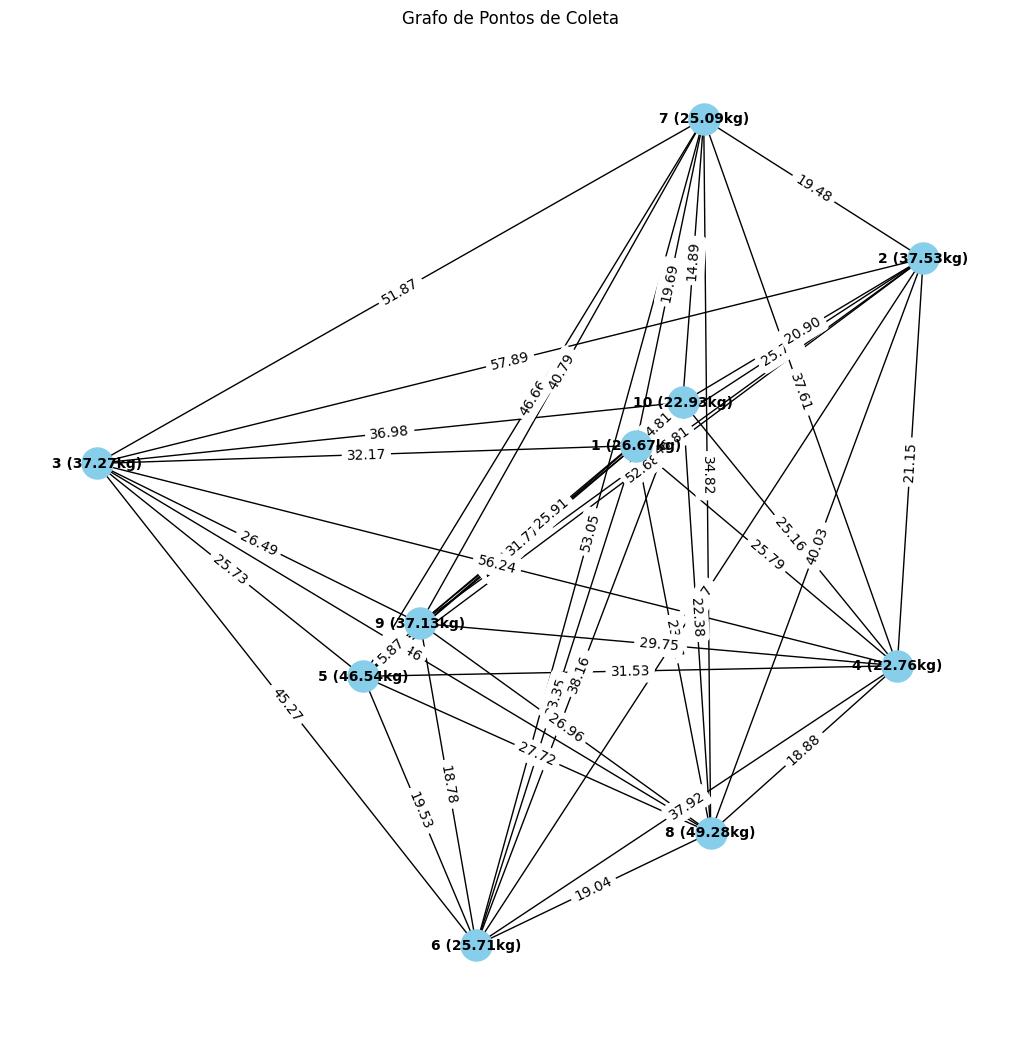

In [ ]:
plotar_grafo(pontos_de_coleta)

In [ ]:
capacidades_veiculos = [7,11]
aco = ACO(pontos_de_coleta, capacidades_veiculos)
pareto = aco.executar()

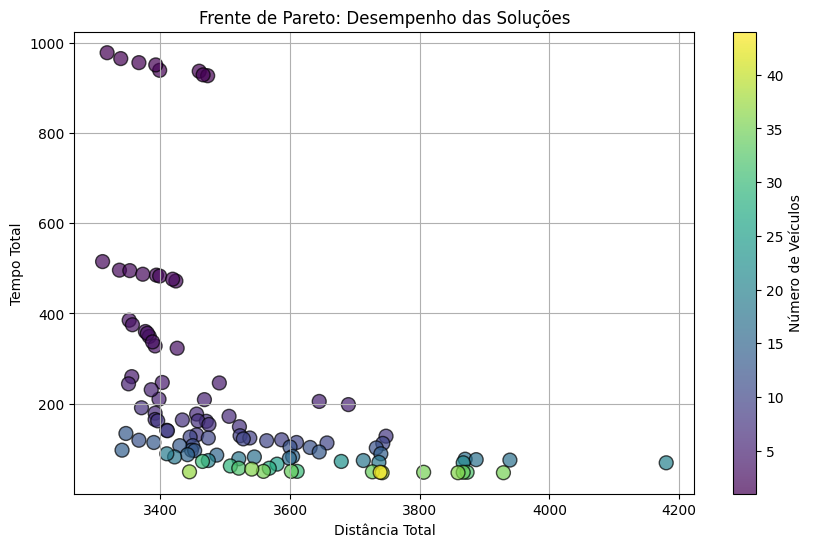

In [ ]:
def plotar_pareto(pareto):
    # Extraindo as métricas das soluções na frente de Pareto
    distancias = [sol[0] for sol in pareto]
    tempos = [sol[1] for sol in pareto]
    num_veiculos = [sol[2] for sol in pareto]

    # Criando um gráfico de dispersão
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(distancias, tempos, c=num_veiculos, cmap='viridis', s=100, edgecolors='k', alpha=0.7)
    plt.colorbar(scatter, label='Número de Veículos')
    plt.xlabel('Distância Total')
    plt.ylabel('Tempo Total')
    plt.title('Frente de Pareto: Desempenho das Soluções')
    plt.grid(True)
    plt.show()

plotar_pareto(pareto)

In [ ]:
(distancia_total, tempo_total, num_veic, solucao, historicos) = pareto[20]
print(f"  Distância Total: {distancia_total:.2f}")
print(f"  Tempo Total: {tempo_total:.2f}")
print(f"  Quantidade Veículos: {num_veic}")
for hist in historicos:
  for histVei in hist:
    print(f" Veículo:{histVei.id_veiculo} ->     Ponto de Coleta {histVei.ponto.id}: Coordenadas ({histVei.ponto.x}, {histVei.ponto.y}), Peso antes da coleta= {histVei.peso_anterior:.2f}, Peso após a coleta= {histVei.peso_atual:.2f}, Valor coletado: {(histVei.peso_anterior-histVei.peso_atual):.2f} ")


  Distância Total: 3380.00
  Tempo Total: 356.00
  Quantidade Veículos: 3
 Veículo:0 ->     Ponto de Coleta 0: Coordenadas (0, 0), Peso antes da coleta= 0.00, Peso após a coleta= 0.00, Valor coletado: 0.00 
 Veículo:0 ->     Ponto de Coleta 3: Coordenadas (0.2635275797357284, 28.718829274468916), Peso antes da coleta= 37.27, Peso após a coleta= 26.27, Valor coletado: 11.00 
 Veículo:0 ->     Ponto de Coleta 0: Coordenadas (0, 0), Peso antes da coleta= 0.00, Peso após a coleta= 0.00, Valor coletado: 0.00 
 Veículo:0 ->     Ponto de Coleta 6: Coordenadas (22.306596387710147, 5.49518958297992), Peso antes da coleta= 25.71, Peso após a coleta= 14.71, Valor coletado: 11.00 
 Veículo:0 ->     Ponto de Coleta 0: Coordenadas (0, 0), Peso antes da coleta= 0.00, Peso após a coleta= 0.00, Valor coletado: 0.00 
 Veículo:0 ->     Ponto de Coleta 9: Coordenadas (19.046683197316128, 21.01043203384713), Peso antes da coleta= 34.11, Peso após a coleta= 23.11, Valor coletado: 11.00 
 Veículo:0 ->     Po